In [255]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import time
import math
import scipy.stats as stats
import itertools

In [159]:
# Load CMPP stock dataset
df_cmpp = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='CMPP.JK')
df_cmpp.set_index('Date', drop=True, inplace=True)
df_cmpp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-04,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-05,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-06,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-07,55788960.0,65707001.0,52069695.0,55788960.0,55788960.0,1205883.0


In [160]:
# Check datatypes
print(df_cmpp.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [161]:
# Check missing value
print(df_cmpp.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [162]:
# Fill missing value using mean imputation
for i in df_cmpp[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_cmpp[i].fillna(df_cmpp[i].mean(), inplace=True)

print(df_cmpp.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


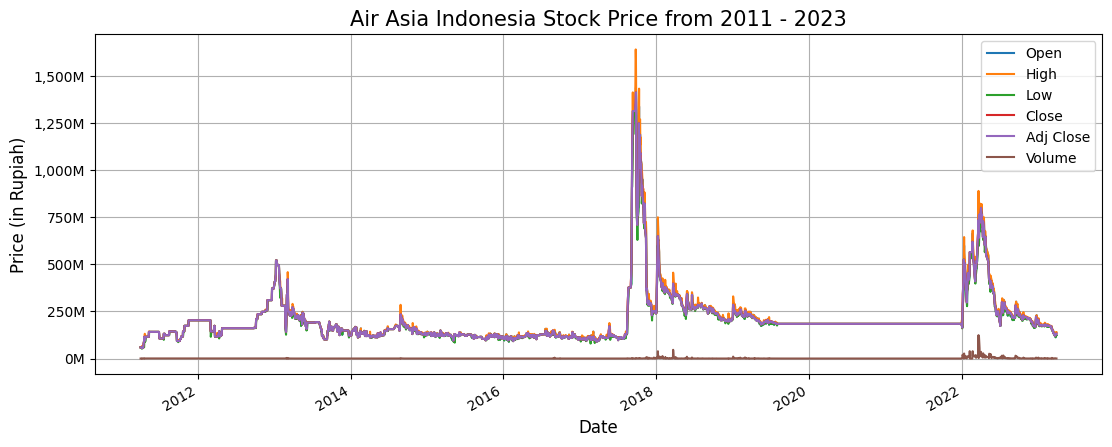

In [163]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_cmpp.plot(figsize=(13,5))
plt.title('Air Asia Indonesia Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [164]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_cmpp[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [165]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.00273973]
 [0.00273973]
 [0.00273973]
 [0.00273973]
 [0.        ]] 

Testing Scaled:  [[0.30954058]
 [0.28596838]
 [0.26976249]
 [0.24913682]
 [0.2299844 ]]


In [166]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [167]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
start_time=time.time()
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 5s 62ms/step - loss: 0.0057 - val_loss: 6.8583e-04
Epoch 2/10
24/24 [==============================] - 1s 30ms/step - loss: 0.0018 - val_loss: 6.0377e-04
Epoch 3/10
24/24 [==============================] - 1s 29ms/step - loss: 0.0014 - val_loss: 5.9466e-04
Epoch 4/10
24/24 [==============================] - 1s 28ms/step - loss: 0.0013 - val_loss: 5.0174e-04
Epoch 5/10
24/24 [==============================] - 1s 28ms/step - loss: 0.0011 - val_loss: 5.2792e-04
Epoch 6/10
24/24 [==============================] - 1s 30ms/step - loss: 0.0010 - val_loss: 4.6525e-04
Epoch 7/10
24/24 [==============================] - 1s 28ms/step - loss: 9.6775e-04 - val_loss: 4.4776e-04
Epoch 8/10
24/24 [==============================] - 1s 35ms/step - loss: 9.0545e-04 - val_loss: 3.9264e-04
Epoch 9/10
24/24 [==============================] - 1s 33ms/step - loss: 8.2824e-04 - val_loss: 3.5307e-04
Epoch 10/10
24/24 [==============================] - 1s 34ms/

In [168]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 8ms/step
Mean Absolute Error (MAE): 0.0089568
Mean Absolute Percentage Error (MAPE): 0.06047
Root Mean Squared Error (RMSE): 0.01478
Mean Squared Error (MSE): 0.0002185
R-Squared (R2): 0.962945
T-Statistic 0.6826
P-Value 6.6257506338795634e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 8ms/step


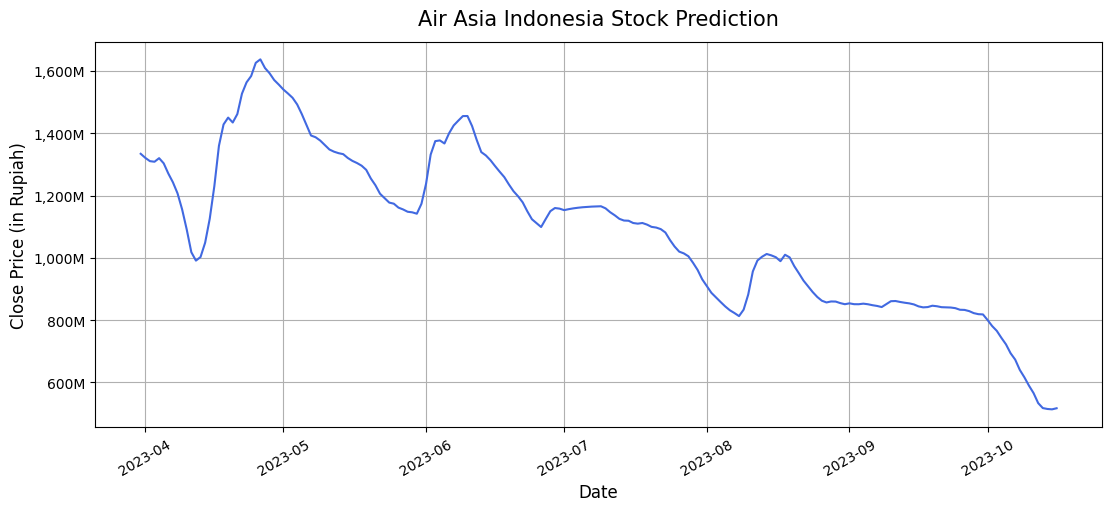

In [169]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [170]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 19s 436ms/step - loss: 0.0057 - val_loss: 9.6397e-04
Epoch 2/10
24/24 [==============================] - 8s 314ms/step - loss: 0.0017 - val_loss: 6.4827e-04
Epoch 3/10
24/24 [==============================] - 8s 350ms/step - loss: 0.0017 - val_loss: 6.1057e-04
Epoch 4/10
24/24 [==============================] - 9s 359ms/step - loss: 0.0015 - val_loss: 5.9511e-04
Epoch 5/10
24/24 [==============================] - 9s 380ms/step - loss: 0.0013 - val_loss: 4.8059e-04
Epoch 6/10
24/24 [==============================] - 9s 389ms/step - loss: 0.0013 - val_loss: 4.5230e-04
Epoch 7/10
24/24 [==============================] - 9s 372ms/step - loss: 9.7596e-04 - val_loss: 3.9083e-04
Epoch 8/10
24/24 [==============================] - 9s 390ms/step - loss: 9.6215e-04 - val_loss: 3.7692e-04
Epoch 9/10
24/24 [==============================] - 9s 382ms/step - loss: 8.5844e-04 - val_loss: 3.6103e-04
Epoch 10/10
24/24 [==============================] 

In [171]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 58ms/step
Mean Absolute Error (MAE): 0.0144744
Mean Absolute Percentage Error (MAPE): 0.10985
Root Mean Squared Error (RMSE): 0.01863
Mean Squared Error (MSE): 0.0003469
R-Squared (R2): 0.941177
T-Statistic 0.7045
P-Value 3.102404218395779e-20
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 58ms/step


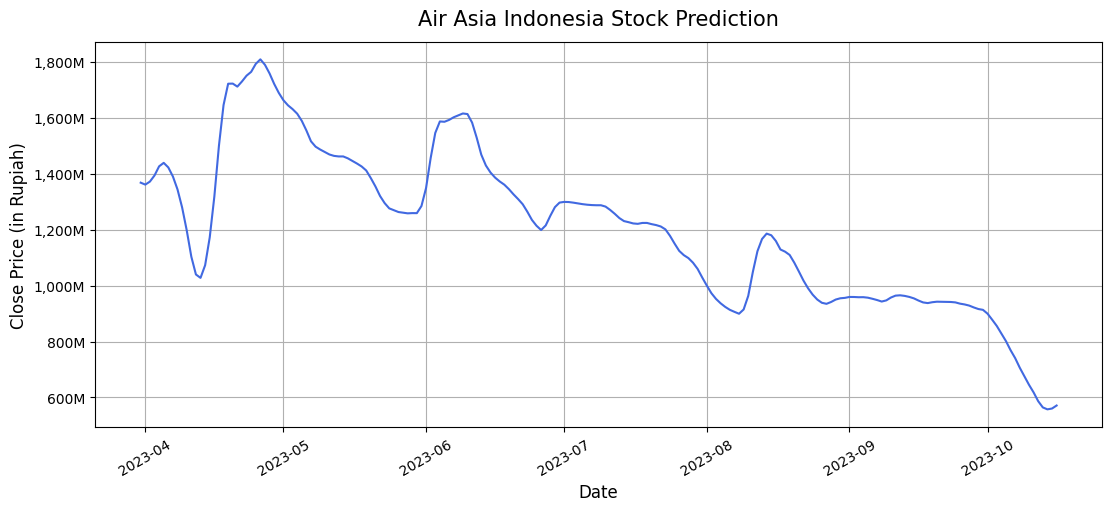

In [172]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [173]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 27s 538ms/step - loss: 0.0180 - val_loss: 0.0019
Epoch 2/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0132 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 10s 397ms/step - loss: 0.0124 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 10s 419ms/step - loss: 0.0122 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 10s 424ms/step - loss: 0.0120 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 10s 428ms/step - loss: 0.0119 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 10s 438ms/step - loss: 0.0115 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0113 - val_loss: 0.0011
Epoch 9/10
24/24 [==============================] - 11s 457ms/step - loss: 0.0112 - val_loss: 0.0011
Epoch 10/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0110 - val_lo

In [174]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 63ms/step
Mean Absolute Error (MAE): 0.0460515
Mean Absolute Percentage Error (MAPE): 0.2771
Root Mean Squared Error (RMSE): 0.08146
Mean Squared Error (MSE): 0.0066358
R-Squared (R2): -0.125167
T-Statistic 0.6737
P-Value 3.599305587185091e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 60ms/step


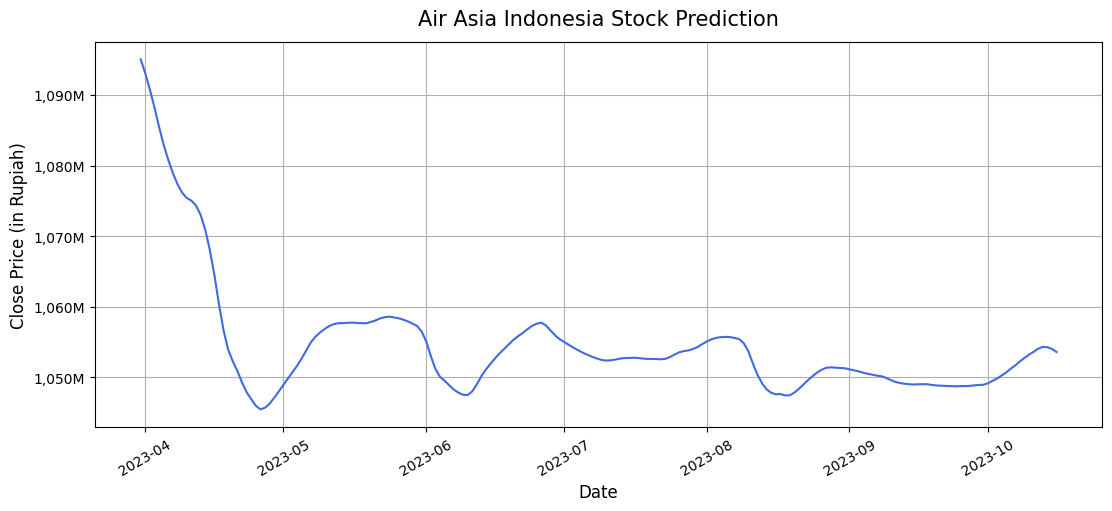

In [175]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [176]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 33s 537ms/step - loss: 0.0041 - val_loss: 7.5692e-04
Epoch 2/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0016 - val_loss: 6.3164e-04
Epoch 3/10
24/24 [==============================] - 9s 392ms/step - loss: 0.0013 - val_loss: 7.2324e-04
Epoch 4/10
24/24 [==============================] - 9s 360ms/step - loss: 0.0013 - val_loss: 6.1523e-04
Epoch 5/10
24/24 [==============================] - 9s 385ms/step - loss: 0.0012 - val_loss: 5.0743e-04
Epoch 6/10
24/24 [==============================] - 10s 413ms/step - loss: 0.0011 - val_loss: 4.3043e-04
Epoch 7/10
24/24 [==============================] - 10s 439ms/step - loss: 9.8449e-04 - val_loss: 3.9202e-04
Epoch 8/10
24/24 [==============================] - 10s 418ms/step - loss: 8.7843e-04 - val_loss: 3.8038e-04
Epoch 9/10
24/24 [==============================] - 11s 441ms/step - loss: 8.3810e-04 - val_loss: 3.2303e-04
Epoch 10/10
24/24 [===========================

In [177]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 60ms/step
Mean Absolute Error (MAE): 0.0149007
Mean Absolute Percentage Error (MAPE): 0.10969
Root Mean Squared Error (RMSE): 0.0197
Mean Squared Error (MSE): 0.0003882
R-Squared (R2): 0.93418
T-Statistic 0.713
P-Value 5.810747347789538e-20
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 57ms/step


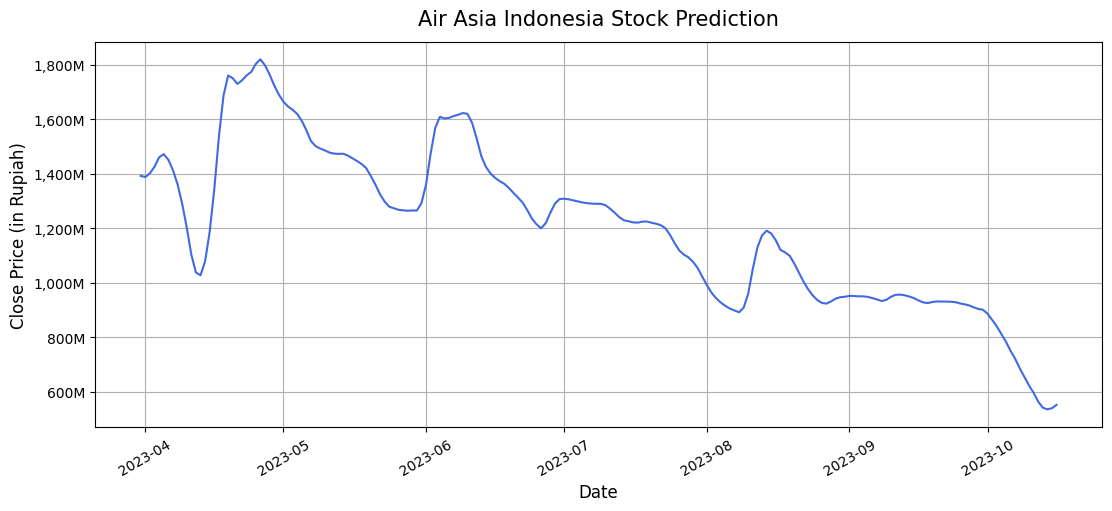

In [178]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [179]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 34s 748ms/step - loss: 0.0047 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 12s 483ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 3/10
24/24 [==============================] - 12s 485ms/step - loss: 0.0021 - val_loss: 7.4938e-04
Epoch 4/10
24/24 [==============================] - 11s 477ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/10
24/24 [==============================] - 10s 429ms/step - loss: 0.0018 - val_loss: 6.5843e-04
Epoch 6/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0017 - val_loss: 8.1855e-04
Epoch 7/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0016 - val_loss: 6.2352e-04
Epoch 8/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0014 - val_loss: 5.7856e-04
Epoch 9/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0015 - val_loss: 5.6230e-04
Epoch 10/10
24/24 [==============================] - 10s 432ms/step

In [180]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 67ms/step
Mean Absolute Error (MAE): 0.0131525
Mean Absolute Percentage Error (MAPE): 0.09045
Root Mean Squared Error (RMSE): 0.02069
Mean Squared Error (MSE): 0.0004279
R-Squared (R2): 0.927444
T-Statistic 0.6784
P-Value 4.956858818091278e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 60ms/step


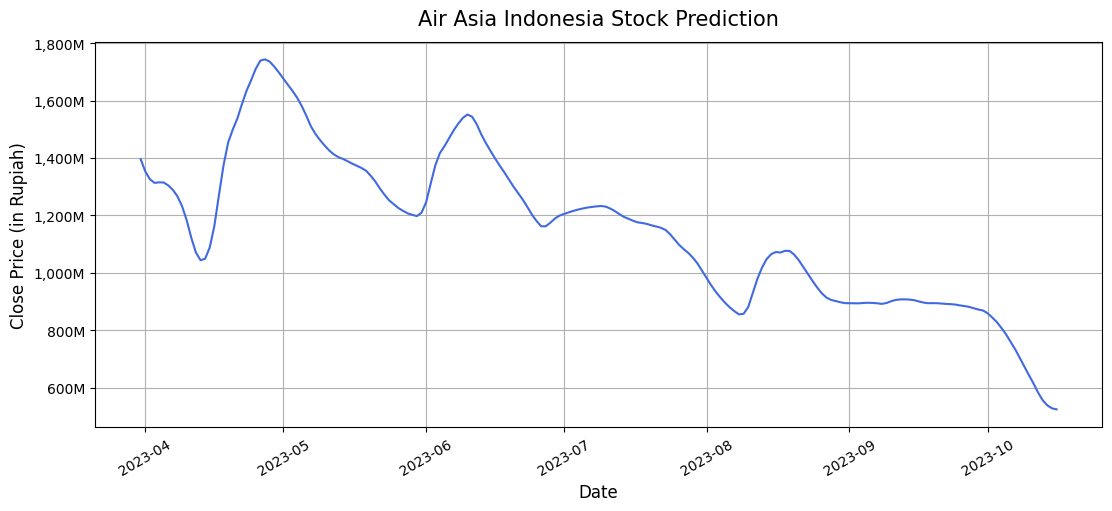

In [181]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [182]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 27s 515ms/step - loss: 0.0244 - val_loss: 0.0118
Epoch 2/10
24/24 [==============================] - 10s 411ms/step - loss: 0.0239 - val_loss: 0.0115
Epoch 3/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0235 - val_loss: 0.0112
Epoch 4/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0231 - val_loss: 0.0109
Epoch 5/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0225 - val_loss: 0.0105
Epoch 6/10
24/24 [==============================] - 10s 424ms/step - loss: 0.0223 - val_loss: 0.0102
Epoch 7/10
24/24 [==============================] - 10s 398ms/step - loss: 0.0218 - val_loss: 0.0100
Epoch 8/10
24/24 [==============================] - 10s 407ms/step - loss: 0.0213 - val_loss: 0.0097
Epoch 9/10
24/24 [==============================] - 9s 394ms/step - loss: 0.0212 - val_loss: 0.0094
Epoch 10/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0206 - val_los

In [183]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 60ms/step
Mean Absolute Error (MAE): 0.1292276
Mean Absolute Percentage Error (MAPE): 0.91943
Root Mean Squared Error (RMSE): 0.15154
Mean Squared Error (MSE): 0.0229649
R-Squared (R2): -2.893911
T-Statistic 0.6482
P-Value 6.794864135629496e-22
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 48ms/step


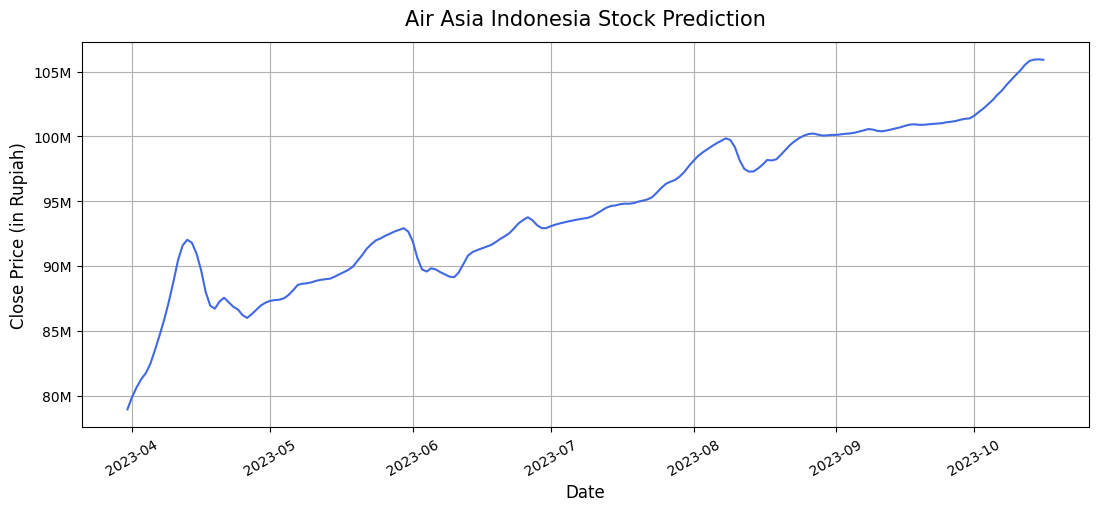

In [184]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [185]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 31s 705ms/step - loss: 0.0111 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 12s 502ms/step - loss: 0.0092 - val_loss: 9.9799e-04
Epoch 3/10
24/24 [==============================] - 12s 508ms/step - loss: 0.0088 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0086 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0084 - val_loss: 9.8255e-04
Epoch 6/10
24/24 [==============================] - 11s 463ms/step - loss: 0.0081 - val_loss: 9.7559e-04
Epoch 7/10
24/24 [==============================] - 11s 465ms/step - loss: 0.0079 - val_loss: 9.6958e-04
Epoch 8/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0073 - val_loss: 9.6343e-04
Epoch 9/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0070 - val_loss: 9.6869e-04
Epoch 10/10
24/24 [==============================] - 10s 412ms/step

In [186]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 49ms/step
Mean Absolute Error (MAE): 0.0330786
Mean Absolute Percentage Error (MAPE): 0.20493
Root Mean Squared Error (RMSE): 0.05787
Mean Squared Error (MSE): 0.0033485
R-Squared (R2): 0.432234
T-Statistic 0.6785
P-Value 4.996470187336841e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 56ms/step


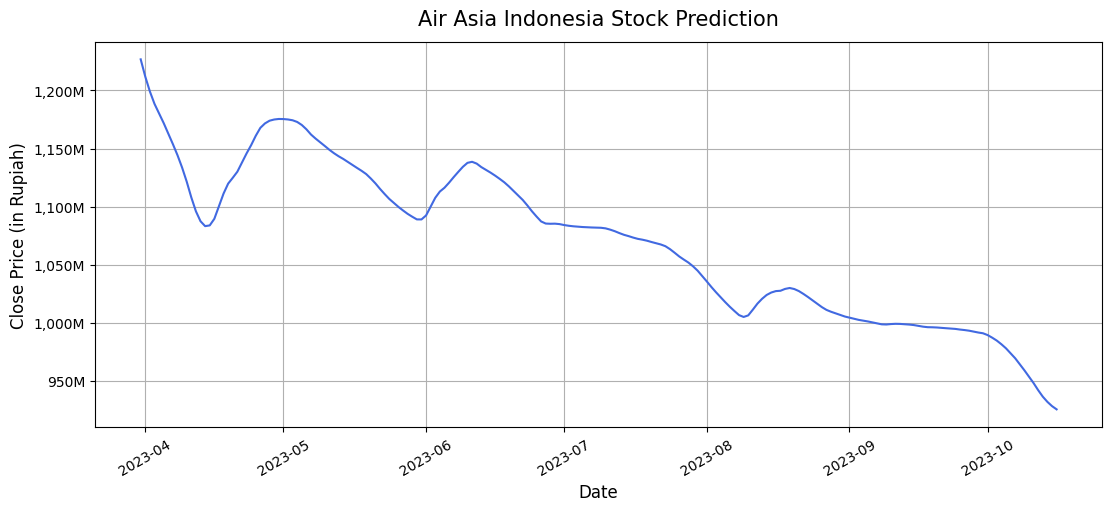

In [187]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [188]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 27s 537ms/step - loss: 0.0051 - val_loss: 8.4259e-04
Epoch 2/10
24/24 [==============================] - 9s 396ms/step - loss: 0.0021 - val_loss: 8.4401e-04
Epoch 3/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0019 - val_loss: 7.6708e-04
Epoch 4/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0017 - val_loss: 7.0708e-04
Epoch 5/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0017 - val_loss: 7.1057e-04
Epoch 6/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0015 - val_loss: 7.4563e-04
Epoch 7/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0015 - val_loss: 6.6848e-04
Epoch 8/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0015 - val_loss: 6.0725e-04
Epoch 9/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0014 - val_loss: 6.3181e-04
Epoch 10/10
24/24 [==============================] - 10s

In [189]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 60ms/step
Mean Absolute Error (MAE): 0.0132086
Mean Absolute Percentage Error (MAPE): 0.10585
Root Mean Squared Error (RMSE): 0.01747
Mean Squared Error (MSE): 0.0003051
R-Squared (R2): 0.948269
T-Statistic 0.6779
P-Value 4.809589165107728e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 62ms/step


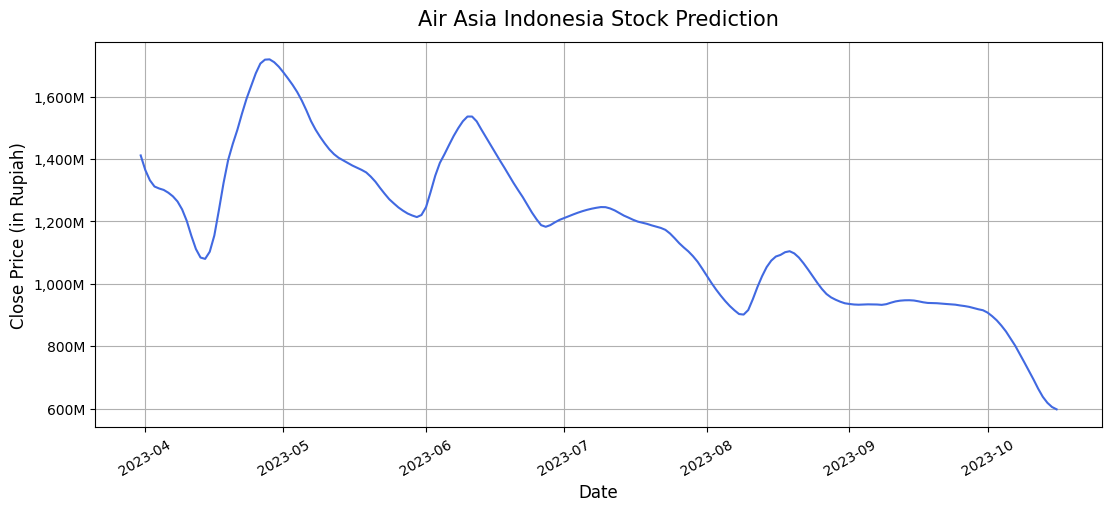

In [190]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [191]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 27s 520ms/step - loss: 0.0061 - val_loss: 0.0014
Epoch 2/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0021 - val_loss: 8.1455e-04
Epoch 3/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0015 - val_loss: 5.9812e-04
Epoch 5/10
24/24 [==============================] - 10s 427ms/step - loss: 0.0013 - val_loss: 5.1521e-04
Epoch 6/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0011 - val_loss: 4.7184e-04
Epoch 7/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0010 - val_loss: 5.7270e-04
Epoch 8/10
24/24 [==============================] - 11s 470ms/step - loss: 9.9452e-04 - val_loss: 3.9169e-04
Epoch 9/10
24/24 [==============================] - 11s 439ms/step - loss: 0.0010 - val_loss: 4.6661e-04
Epoch 10/10
24/24 [==============================] - 12s 48

In [192]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 62ms/step
Mean Absolute Error (MAE): 0.0088571
Mean Absolute Percentage Error (MAPE): 0.06176
Root Mean Squared Error (RMSE): 0.01418
Mean Squared Error (MSE): 0.0002011
R-Squared (R2): 0.965907
T-Statistic 0.7045
P-Value 3.103444333392579e-20
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 62ms/step


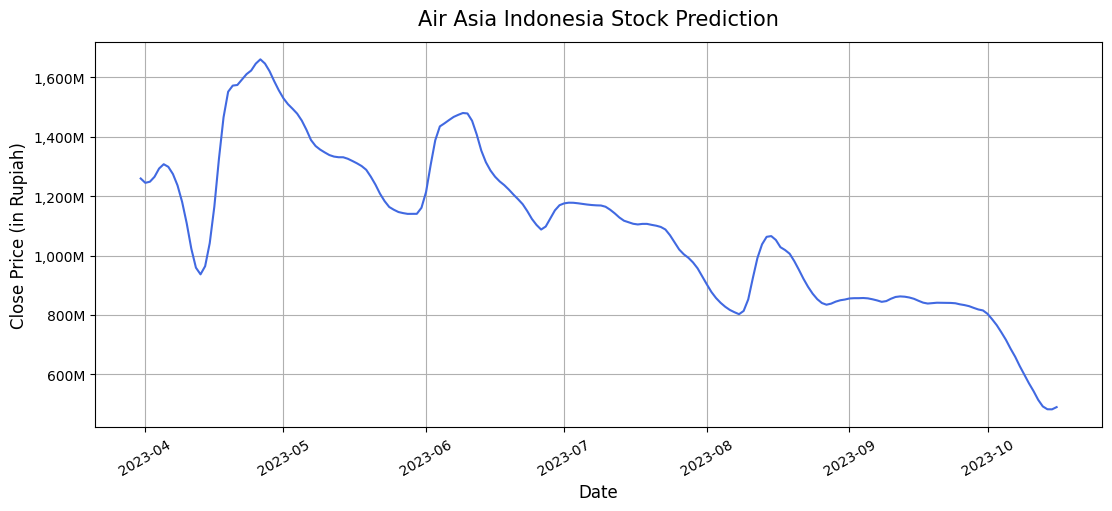

In [193]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [194]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 26s 552ms/step - loss: 0.0200 - val_loss: 0.0048
Epoch 2/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0152 - val_loss: 0.0028
Epoch 3/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0130 - val_loss: 0.0019
Epoch 4/10
24/24 [==============================] - 10s 396ms/step - loss: 0.0119 - val_loss: 0.0014
Epoch 5/10
24/24 [==============================] - 9s 388ms/step - loss: 0.0110 - val_loss: 0.0012
Epoch 6/10
24/24 [==============================] - 9s 381ms/step - loss: 0.0108 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 10s 412ms/step - loss: 0.0104 - val_loss: 0.0010
Epoch 8/10
24/24 [==============================] - 10s 418ms/step - loss: 0.0099 - val_loss: 9.9160e-04
Epoch 9/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0100 - val_loss: 9.7881e-04
Epoch 10/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0099 - 

In [195]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 66ms/step
Mean Absolute Error (MAE): 0.0424249
Mean Absolute Percentage Error (MAPE): 0.24378
Root Mean Squared Error (RMSE): 0.07555
Mean Squared Error (MSE): 0.0057079
R-Squared (R2): 0.032168
T-Statistic 0.8146
P-Value 3.867715491005482e-16
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 61ms/step


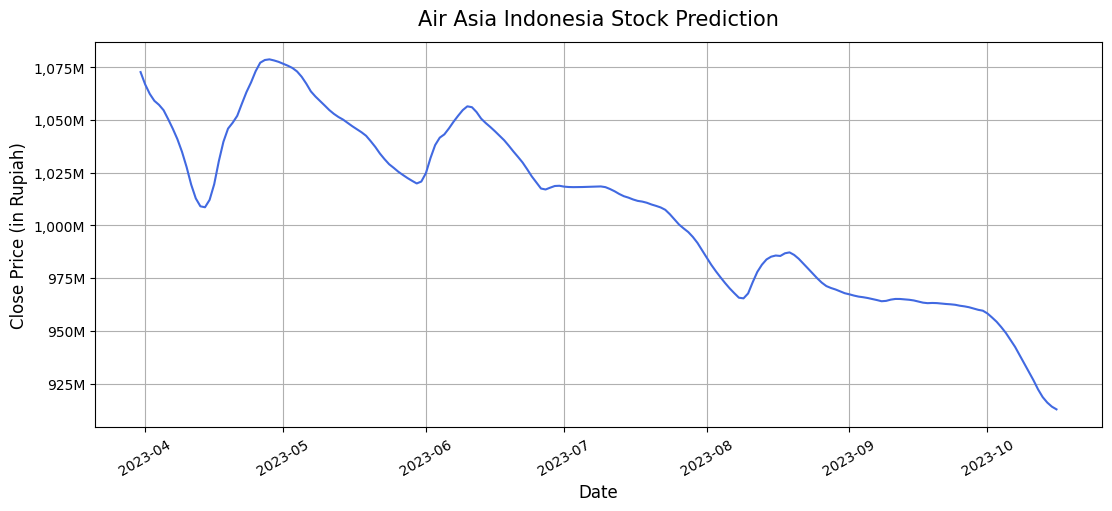

In [196]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [197]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 30s 592ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 2/10
24/24 [==============================] - 11s 439ms/step - loss: 0.0020 - val_loss: 6.7060e-04
Epoch 3/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0016 - val_loss: 7.1377e-04
Epoch 4/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0015 - val_loss: 5.7967e-04
Epoch 5/10
24/24 [==============================] - 10s 419ms/step - loss: 0.0012 - val_loss: 4.8281e-04
Epoch 6/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0011 - val_loss: 4.5864e-04
Epoch 7/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0012 - val_loss: 4.0318e-04
Epoch 8/10
24/24 [==============================] - 11s 443ms/step - loss: 0.0010 - val_loss: 3.9473e-04
Epoch 9/10
24/24 [==============================] - 10s 417ms/step - loss: 8.7823e-04 - val_loss: 3.5908e-04
Epoch 10/10
24/24 [==============================] - 10s 

In [198]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 5s 73ms/step
Mean Absolute Error (MAE): 0.0110781
Mean Absolute Percentage Error (MAPE): 0.07379
Root Mean Squared Error (RMSE): 0.01791
Mean Squared Error (MSE): 0.0003207
R-Squared (R2): 0.94563
T-Statistic 0.7248
P-Value 1.4154536281187828e-19
Elapsed Time (min): 11.38


7/7 [==============================] - 1s 68ms/step


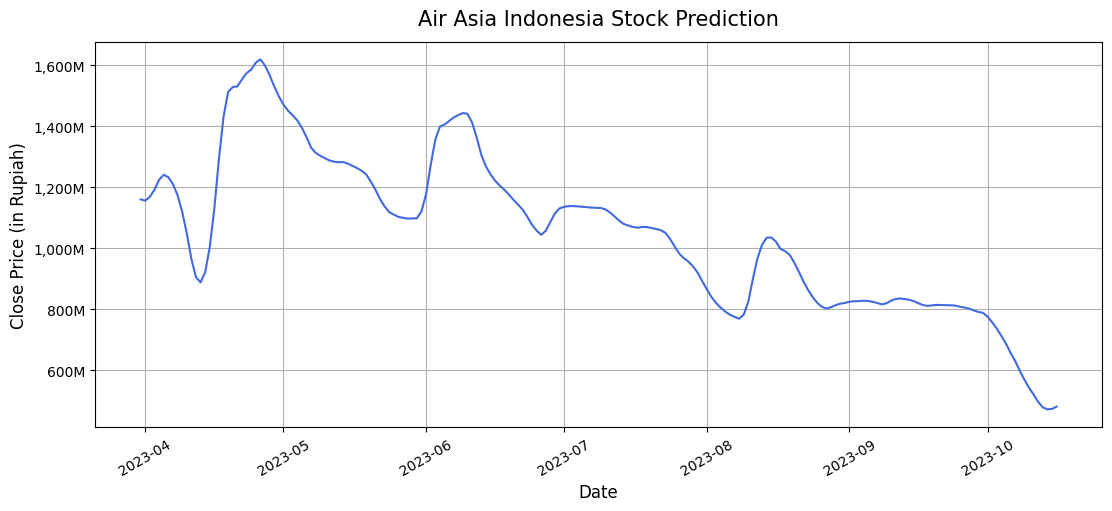

In [199]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [200]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 32s 691ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 2/10
24/24 [==============================] - 12s 499ms/step - loss: 0.0030 - val_loss: 9.2270e-04
Epoch 3/10
24/24 [==============================] - 11s 471ms/step - loss: 0.0023 - val_loss: 7.4110e-04
Epoch 4/10
24/24 [==============================] - 11s 462ms/step - loss: 0.0019 - val_loss: 7.3439e-04
Epoch 5/10
24/24 [==============================] - 11s 481ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 12s 481ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 7/10
24/24 [==============================] - 11s 476ms/step - loss: 0.0016 - val_loss: 6.1419e-04
Epoch 8/10
24/24 [==============================] - 12s 490ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 9/10
24/24 [==============================] - 12s 503ms/step - loss: 0.0015 - val_loss: 5.3443e-04
Epoch 10/10
24/24 [==============================] - 11s 441ms/step - l

In [201]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 52ms/step
Mean Absolute Error (MAE): 0.0271123
Mean Absolute Percentage Error (MAPE): 0.21217
Root Mean Squared Error (RMSE): 0.03129
Mean Squared Error (MSE): 0.0009792
R-Squared (R2): 0.83396
T-Statistic 0.6884
P-Value 9.862778173850921e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 51ms/step


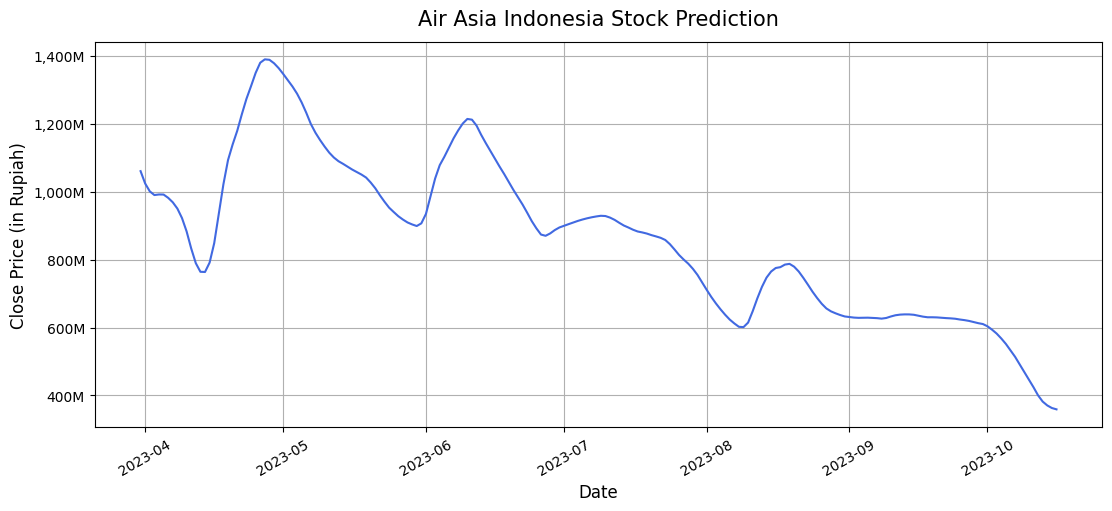

In [202]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [203]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 27s 569ms/step - loss: 0.0150 - val_loss: 0.0076
Epoch 2/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0144 - val_loss: 0.0074
Epoch 3/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0144 - val_loss: 0.0072
Epoch 4/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0142 - val_loss: 0.0070
Epoch 5/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0140 - val_loss: 0.0068
Epoch 6/10
24/24 [==============================] - 11s 453ms/step - loss: 0.0136 - val_loss: 0.0067
Epoch 7/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0134 - val_loss: 0.0065
Epoch 8/10
24/24 [==============================] - 11s 441ms/step - loss: 0.0135 - val_loss: 0.0063
Epoch 9/10
24/24 [==============================] - 11s 441ms/step - loss: 0.0133 - val_loss: 0.0061
Epoch 10/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0130 - val_lo

In [204]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 66ms/step
Mean Absolute Error (MAE): 0.0965398
Mean Absolute Percentage Error (MAPE): 0.68894
Root Mean Squared Error (RMSE): 0.1129
Mean Squared Error (MSE): 0.0127461
R-Squared (R2): -1.161209
T-Statistic 0.689
P-Value 1.0306475754161091e-20
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 66ms/step


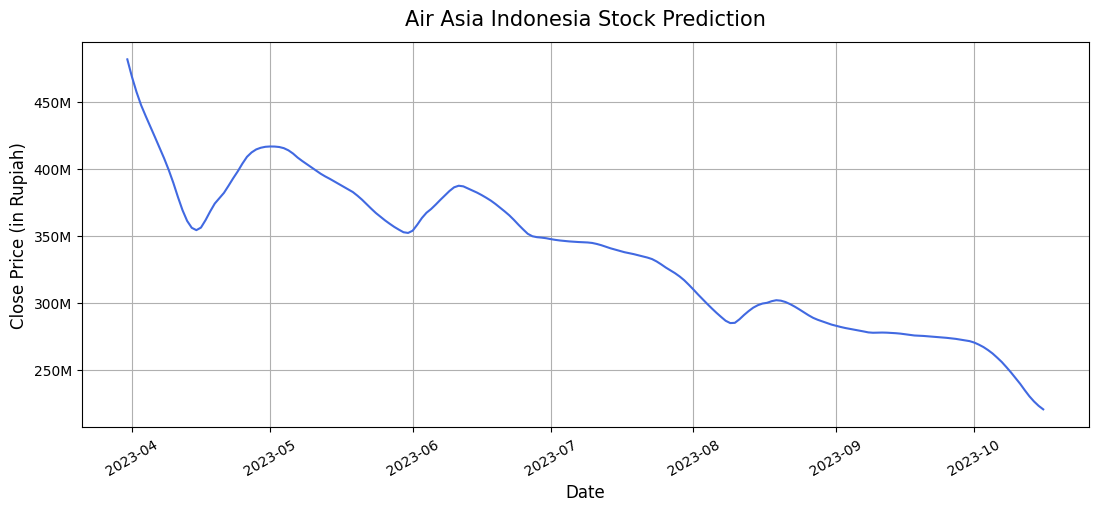

In [205]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [206]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 25s 514ms/step - loss: 0.0112 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0088 - val_loss: 0.0010
Epoch 3/10
24/24 [==============================] - 11s 441ms/step - loss: 0.0085 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0083 - val_loss: 9.9694e-04
Epoch 5/10
24/24 [==============================] - 12s 491ms/step - loss: 0.0081 - val_loss: 9.9399e-04
Epoch 6/10
24/24 [==============================] - 11s 475ms/step - loss: 0.0077 - val_loss: 9.8926e-04
Epoch 7/10
24/24 [==============================] - 12s 492ms/step - loss: 0.0077 - val_loss: 9.8525e-04
Epoch 8/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0074 - val_loss: 9.8179e-04
Epoch 9/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0070 - val_loss: 9.8575e-04
Epoch 10/10
24/24 [==============================] - 11s 477ms/step

In [207]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 71ms/step
Mean Absolute Error (MAE): 0.0309215
Mean Absolute Percentage Error (MAPE): 0.19632
Root Mean Squared Error (RMSE): 0.05475
Mean Squared Error (MSE): 0.0029975
R-Squared (R2): 0.491745
T-Statistic 0.6847
P-Value 7.651566068957556e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 1s 73ms/step


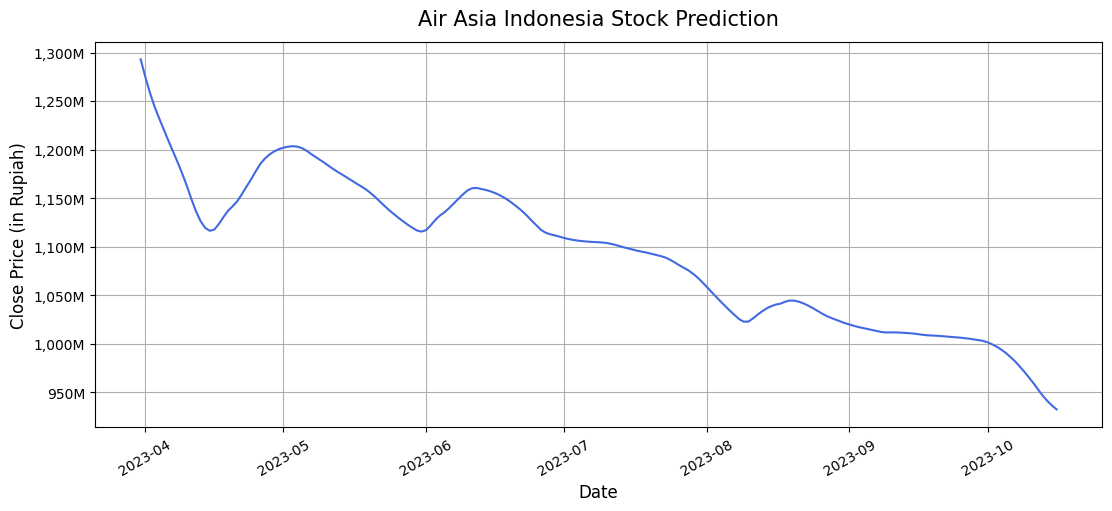

In [208]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [209]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 29s 598ms/step - loss: 0.0049 - val_loss: 8.8264e-04
Epoch 2/10
24/24 [==============================] - 11s 439ms/step - loss: 0.0025 - val_loss: 8.7340e-04
Epoch 3/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0020 - val_loss: 7.7514e-04
Epoch 4/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0019 - val_loss: 7.7062e-04
Epoch 5/10
24/24 [==============================] - 9s 397ms/step - loss: 0.0018 - val_loss: 8.1792e-04
Epoch 6/10
24/24 [==============================] - 10s 429ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 7/10
24/24 [==============================] - 11s 464ms/step - loss: 0.0016 - val_loss: 7.1122e-04
Epoch 8/10
24/24 [==============================] - 11s 451ms/step - loss: 0.0016 - val_loss: 6.5432e-04
Epoch 9/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0015 - val_loss: 6.7698e-04
Epoch 10/10
24/24 [==============================] - 11s 440

In [210]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 64ms/step
Mean Absolute Error (MAE): 0.0143357
Mean Absolute Percentage Error (MAPE): 0.09938
Root Mean Squared Error (RMSE): 0.02166
Mean Squared Error (MSE): 0.0004692
R-Squared (R2): 0.920437
T-Statistic 0.6907
P-Value 1.1638920741522669e-20
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 62ms/step


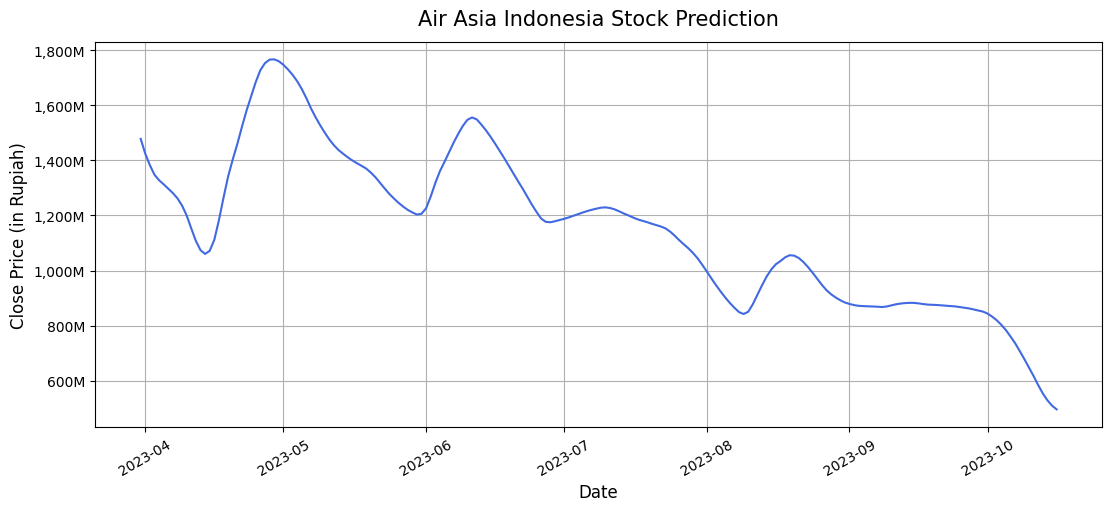

In [211]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [212]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 30s 628ms/step - loss: 0.4026 - val_loss: 0.0195
Epoch 2/10
24/24 [==============================] - 11s 446ms/step - loss: 0.0199 - val_loss: 0.0013
Epoch 3/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0159 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0147 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 11s 451ms/step - loss: 0.0138 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 11s 467ms/step - loss: 0.0135 - val_loss: 0.0014
Epoch 7/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0127 - val_loss: 0.0013
Epoch 8/10
24/24 [==============================] - 10s 429ms/step - loss: 0.0115 - val_loss: 0.0013
Epoch 9/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 10/10
24/24 [==============================] - 10s 429ms/step - loss: 0.0080 - val_lo

In [213]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 5s 75ms/step
Mean Absolute Error (MAE): 0.0337618
Mean Absolute Percentage Error (MAPE): 0.24269
Root Mean Squared Error (RMSE): 0.0555
Mean Squared Error (MSE): 0.0030803
R-Squared (R2): 0.4777
T-Statistic 0.6804
P-Value 5.692210265747415e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 1s 74ms/step


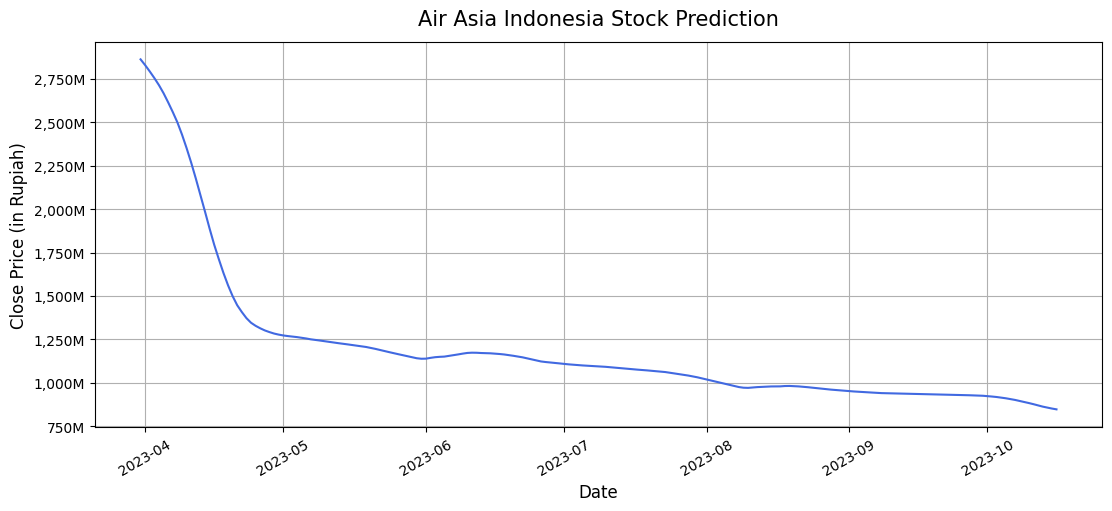

In [214]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [215]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 32s 683ms/step - loss: 3.1728 - val_loss: 2.9039
Epoch 2/10
24/24 [==============================] - 10s 424ms/step - loss: 2.7405 - val_loss: 2.5863
Epoch 3/10
24/24 [==============================] - 10s 421ms/step - loss: 2.4614 - val_loss: 2.3373
Epoch 4/10
24/24 [==============================] - 11s 441ms/step - loss: 2.2266 - val_loss: 2.1115
Epoch 5/10
24/24 [==============================] - 10s 427ms/step - loss: 2.0019 - val_loss: 1.8833
Epoch 6/10
24/24 [==============================] - 10s 422ms/step - loss: 1.7671 - val_loss: 1.6303
Epoch 7/10
24/24 [==============================] - 10s 422ms/step - loss: 1.4949 - val_loss: 1.3352
Epoch 8/10
24/24 [==============================] - 10s 409ms/step - loss: 1.1916 - val_loss: 1.0156
Epoch 9/10
24/24 [==============================] - 10s 421ms/step - loss: 0.8809 - val_loss: 0.7262
Epoch 10/10
24/24 [==============================] - 9s 388ms/step - loss: 0.6249 - val_los

In [216]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 55ms/step
Mean Absolute Error (MAE): 0.6633237
Mean Absolute Percentage Error (MAPE): 6.03385
Root Mean Squared Error (RMSE): 0.66876
Mean Squared Error (MSE): 0.4472438
R-Squared (R2): -74.834185
T-Statistic 0.7389
P-Value 4.240494105861816e-19
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 66ms/step


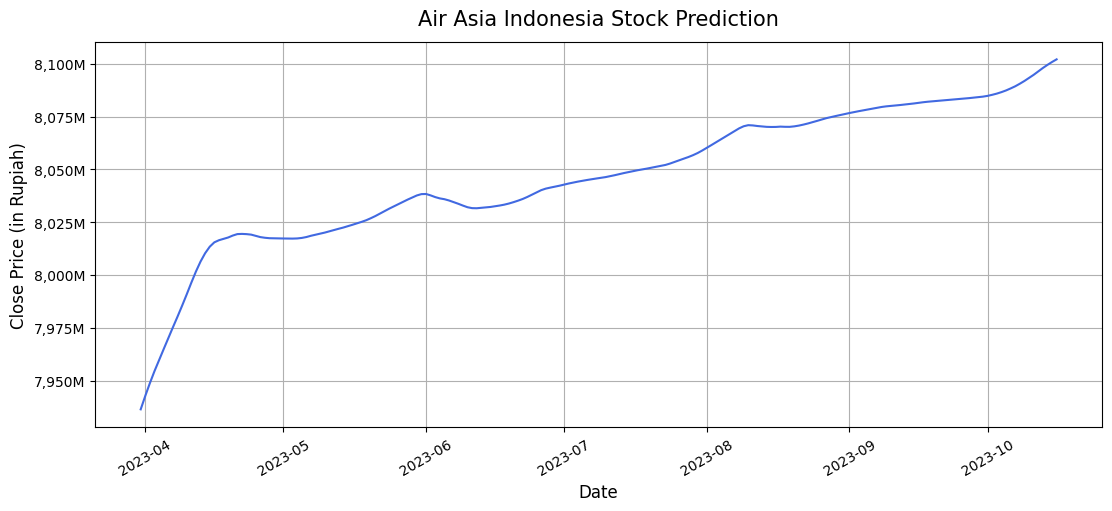

In [217]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [218]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 27s 611ms/step - loss: 0.0058 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 10s 425ms/step - loss: 0.0021 - val_loss: 7.7358e-04
Epoch 3/10
24/24 [==============================] - 11s 443ms/step - loss: 0.0018 - val_loss: 7.7013e-04
Epoch 4/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0013 - val_loss: 7.2126e-04
Epoch 5/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0015 - val_loss: 6.8396e-04
Epoch 6/10
24/24 [==============================] - 11s 454ms/step - loss: 0.0013 - val_loss: 5.8125e-04
Epoch 7/10
24/24 [==============================] - 11s 467ms/step - loss: 0.0011 - val_loss: 5.2612e-04
Epoch 8/10
24/24 [==============================] - 12s 482ms/step - loss: 0.0010 - val_loss: 5.2371e-04
Epoch 9/10
24/24 [==============================] - 12s 485ms/step - loss: 0.0011 - val_loss: 4.7052e-04
Epoch 10/10
24/24 [==============================] - 12s 48

In [219]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 6s 74ms/step
Mean Absolute Error (MAE): 0.0098455
Mean Absolute Percentage Error (MAPE): 0.07326
Root Mean Squared Error (RMSE): 0.01469
Mean Squared Error (MSE): 0.0002159
R-Squared (R2): 0.9634
T-Statistic 0.6993
P-Value 2.1318517183784307e-20
Elapsed Time (min): 11.38


7/7 [==============================] - 1s 80ms/step


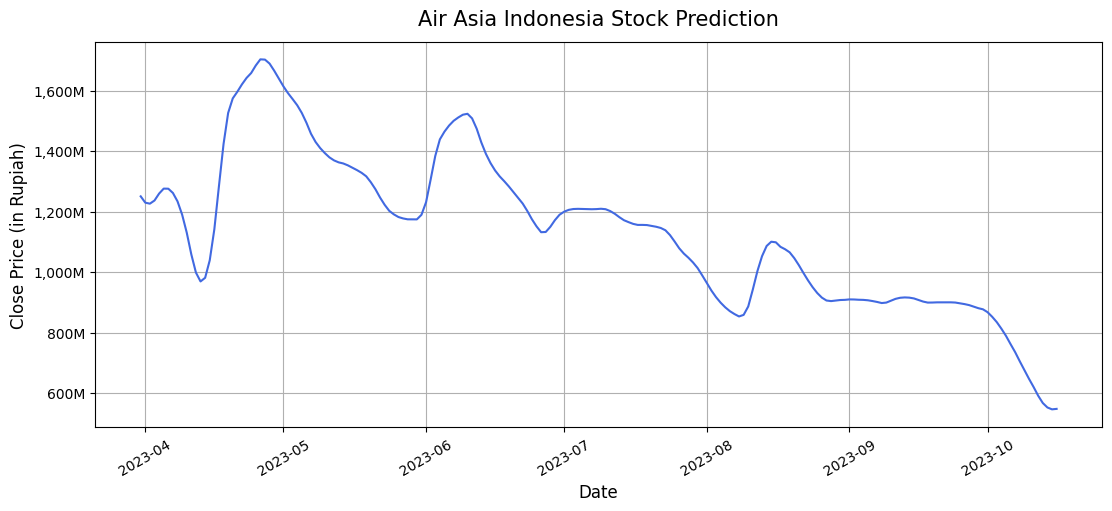

In [220]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [221]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 30s 514ms/step - loss: 0.0129 - val_loss: 9.7186e-04
Epoch 2/10
24/24 [==============================] - 10s 408ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 10s 434ms/step - loss: 0.0032 - val_loss: 8.9818e-04
Epoch 4/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 5/10
24/24 [==============================] - 10s 421ms/step - loss: 0.0025 - val_loss: 9.6529e-04
Epoch 6/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0023 - val_loss: 7.8208e-04
Epoch 7/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0022 - val_loss: 7.6103e-04
Epoch 8/10
24/24 [==============================] - 10s 438ms/step - loss: 0.0021 - val_loss: 9.3253e-04
Epoch 9/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/10
24/24 [==============================] - 10s 428ms/step

In [222]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 63ms/step
Mean Absolute Error (MAE): 0.0320987
Mean Absolute Percentage Error (MAPE): 0.29909
Root Mean Squared Error (RMSE): 0.03476
Mean Squared Error (MSE): 0.001208
R-Squared (R2): 0.795176
T-Statistic 0.6534
P-Value 9.482549337992506e-22
Elapsed Time (min): 11.38


7/7 [==============================] - 1s 70ms/step


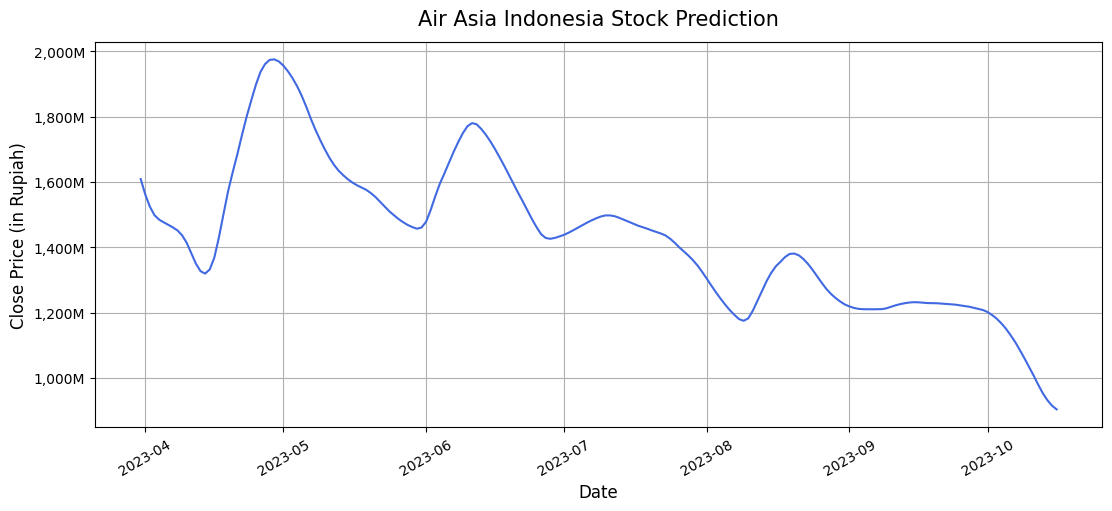

In [223]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [224]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 31s 595ms/step - loss: 0.2561 - val_loss: 0.2499
Epoch 2/10
24/24 [==============================] - 12s 482ms/step - loss: 0.2550 - val_loss: 0.2488
Epoch 3/10
24/24 [==============================] - 11s 448ms/step - loss: 0.2539 - val_loss: 0.2477
Epoch 4/10
24/24 [==============================] - 10s 404ms/step - loss: 0.2529 - val_loss: 0.2466
Epoch 5/10
24/24 [==============================] - 9s 394ms/step - loss: 0.2517 - val_loss: 0.2454
Epoch 6/10
24/24 [==============================] - 10s 405ms/step - loss: 0.2506 - val_loss: 0.2443
Epoch 7/10
24/24 [==============================] - 9s 393ms/step - loss: 0.2495 - val_loss: 0.2431
Epoch 8/10
24/24 [==============================] - 10s 406ms/step - loss: 0.2483 - val_loss: 0.2419
Epoch 9/10
24/24 [==============================] - 10s 427ms/step - loss: 0.2471 - val_loss: 0.2407
Epoch 10/10
24/24 [==============================] - 10s 435ms/step - loss: 0.2459 - val_loss

In [225]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 68ms/step
Mean Absolute Error (MAE): 0.4489221
Mean Absolute Percentage Error (MAPE): 4.13836
Root Mean Squared Error (RMSE): 0.45571
Mean Squared Error (MSE): 0.2076692
R-Squared (R2): -34.21217
T-Statistic 0.7053
P-Value 3.289990363629479e-20
Elapsed Time (min): 11.38


7/7 [==============================] - 1s 71ms/step


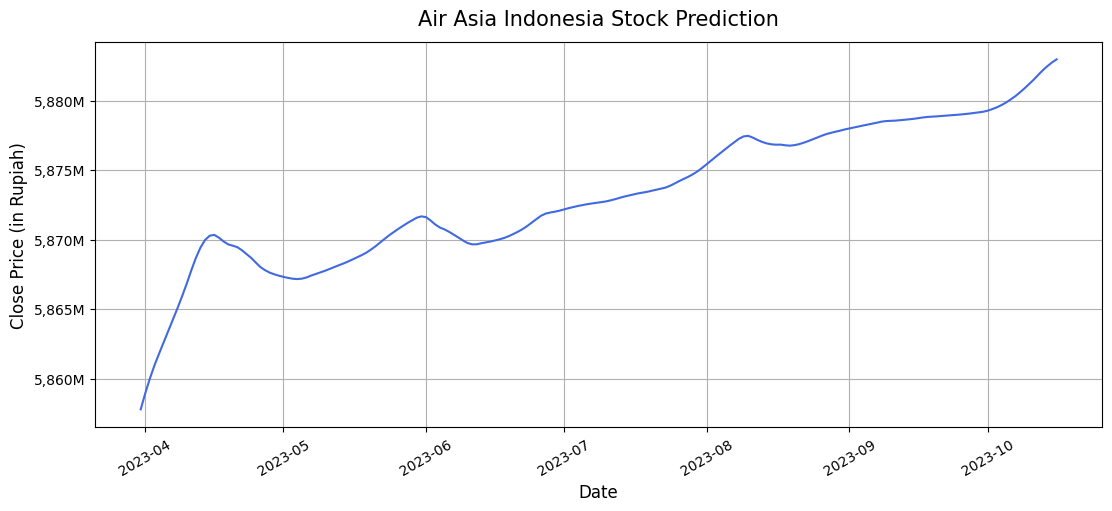

In [226]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [227]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 33s 640ms/step - loss: 0.1080 - val_loss: 0.0011
Epoch 2/10
24/24 [==============================] - 11s 464ms/step - loss: 0.0108 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 11s 455ms/step - loss: 0.0108 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 11s 460ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 11s 474ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0106 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0106 - val_loss: 0.0011
Epoch 9/10
24/24 [==============================] - 10s 421ms/step - loss: 0.0105 - val_loss: 0.0011
Epoch 10/10
24/24 [==============================] - 10s 426ms/step - loss: 0.0104 - val_lo

In [228]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 68ms/step
Mean Absolute Error (MAE): 0.0452828
Mean Absolute Percentage Error (MAPE): 0.2703
Root Mean Squared Error (RMSE): 0.07991
Mean Squared Error (MSE): 0.0063856
R-Squared (R2): -0.082729
T-Statistic 0.6995
P-Value 2.1695461127102735e-20
Elapsed Time (min): 11.38


7/7 [==============================] - 1s 64ms/step


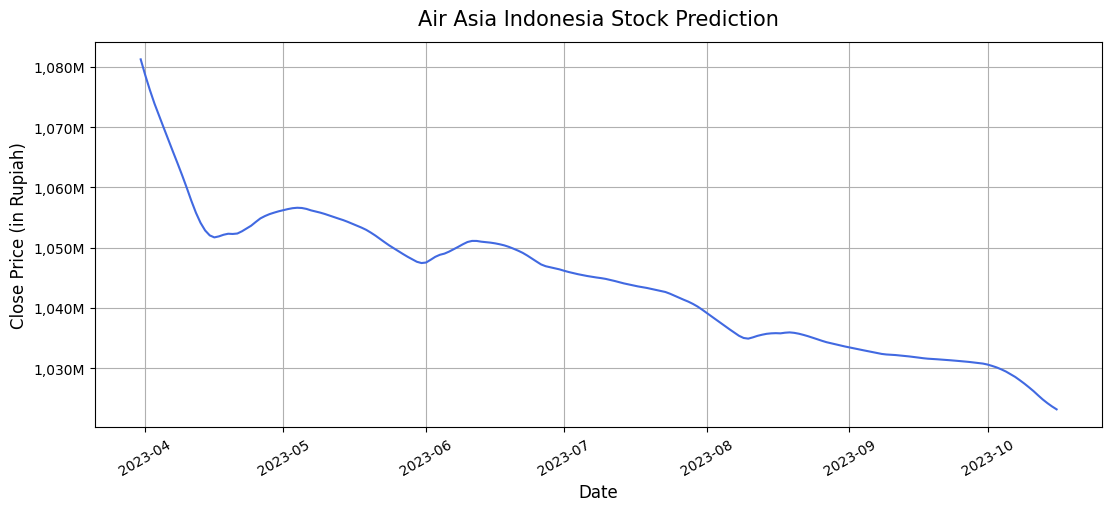

In [229]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [230]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 29s 562ms/step - loss: 0.0389 - val_loss: 0.0027
Epoch 2/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0116 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 10s 413ms/step - loss: 0.0051 - val_loss: 9.7010e-04
Epoch 4/10
24/24 [==============================] - 10s 422ms/step - loss: 0.0036 - val_loss: 9.4580e-04
Epoch 5/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0030 - val_loss: 8.9784e-04
Epoch 6/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0026 - val_loss: 8.6790e-04
Epoch 7/10
24/24 [==============================] - 10s 413ms/step - loss: 0.0023 - val_loss: 8.5327e-04
Epoch 8/10
24/24 [==============================] - 10s 420ms/step - loss: 0.0021 - val_loss: 8.5281e-04
Epoch 9/10
24/24 [==============================] - 10s 416ms/step - loss: 0.0019 - val_loss: 7.9190e-04
Epoch 10/10
24/24 [==============================] - 10s 416ms/

In [231]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 61ms/step
Mean Absolute Error (MAE): 0.024963
Mean Absolute Percentage Error (MAPE): 0.17214
Root Mean Squared Error (RMSE): 0.03617
Mean Squared Error (MSE): 0.0013083
R-Squared (R2): 0.778171
T-Statistic 0.6488
P-Value 7.081190099530473e-22
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 52ms/step


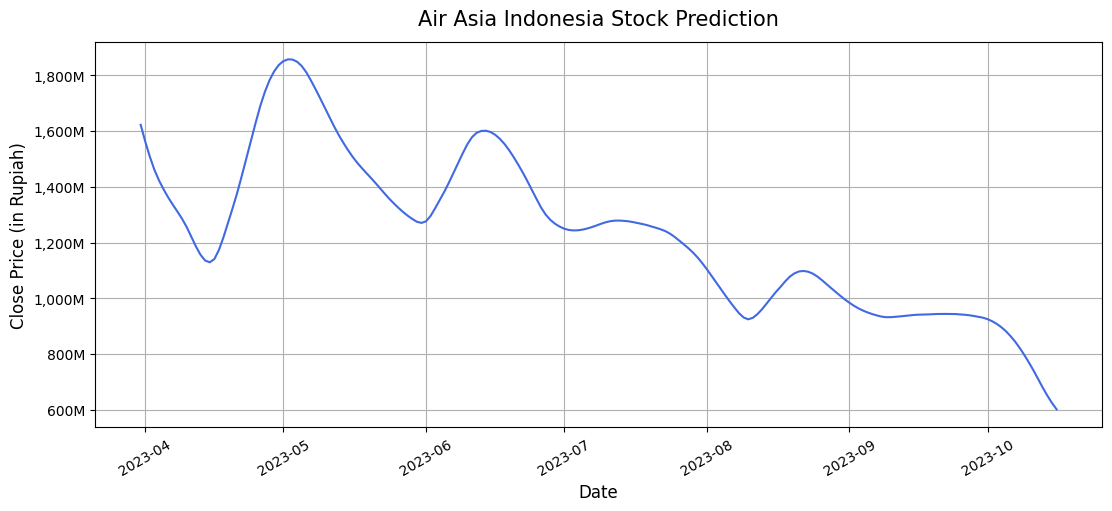

In [232]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [233]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 21s 487ms/step - loss: 0.0042 - val_loss: 8.4439e-04
Epoch 2/10
24/24 [==============================] - 10s 402ms/step - loss: 0.0015 - val_loss: 6.3790e-04
Epoch 3/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0014 - val_loss: 5.4925e-04
Epoch 4/10
24/24 [==============================] - 10s 429ms/step - loss: 0.0012 - val_loss: 5.1513e-04
Epoch 5/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0013 - val_loss: 4.4524e-04
Epoch 6/10
24/24 [==============================] - 10s 411ms/step - loss: 0.0011 - val_loss: 4.2360e-04
Epoch 7/10
24/24 [==============================] - 10s 438ms/step - loss: 9.2809e-04 - val_loss: 3.9877e-04
Epoch 8/10
24/24 [==============================] - 10s 434ms/step - loss: 8.1380e-04 - val_loss: 3.8197e-04
Epoch 9/10
24/24 [==============================] - 10s 423ms/step - loss: 7.8398e-04 - val_loss: 3.4914e-04
Epoch 10/10
24/24 [========================

In [234]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 0.0157169
Mean Absolute Percentage Error (MAPE): 0.1318
Root Mean Squared Error (RMSE): 0.0181
Mean Squared Error (MSE): 0.0003277
R-Squared (R2): 0.944435
T-Statistic 0.7058
P-Value 3.4133947250298804e-20
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 52ms/step


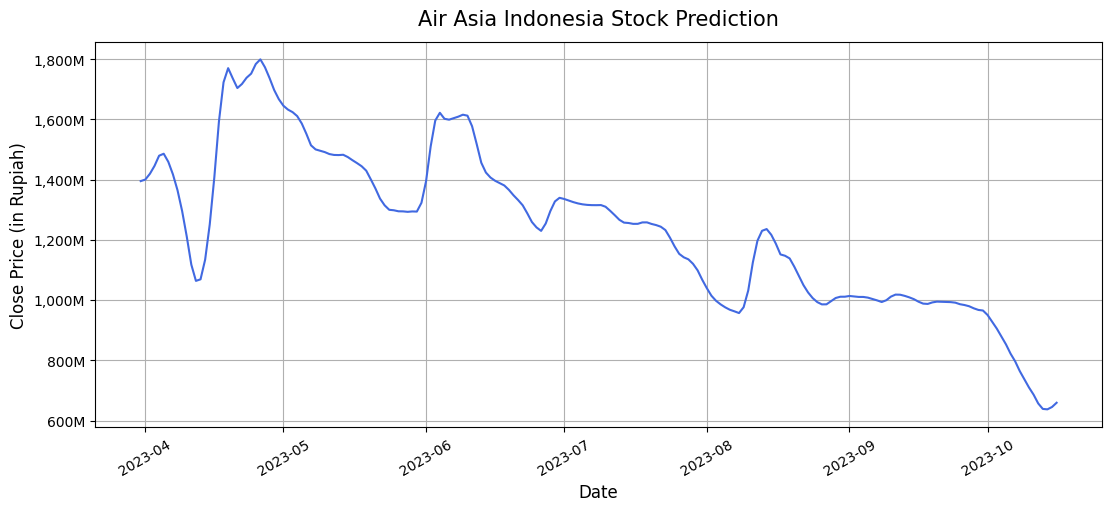

In [235]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [236]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 20s 512ms/step - loss: 0.0158 - val_loss: 0.0024
Epoch 2/10
24/24 [==============================] - 10s 433ms/step - loss: 0.0115 - val_loss: 0.0012
Epoch 3/10
24/24 [==============================] - 10s 419ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 10s 420ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0106 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 10s 414ms/step - loss: 0.0103 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0101 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 10s 420ms/step - loss: 0.0101 - val_loss: 0.0011
Epoch 9/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0099 - val_loss: 0.0011
Epoch 10/10
24/24 [==============================] - 10s 422ms/step - loss: 0.0098 - val_lo

In [237]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 51ms/step
Mean Absolute Error (MAE): 0.0430917
Mean Absolute Percentage Error (MAPE): 0.26013
Root Mean Squared Error (RMSE): 0.07576
Mean Squared Error (MSE): 0.00574
R-Squared (R2): 0.026726
T-Statistic 0.6675
P-Value 2.3807940259379302e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 50ms/step


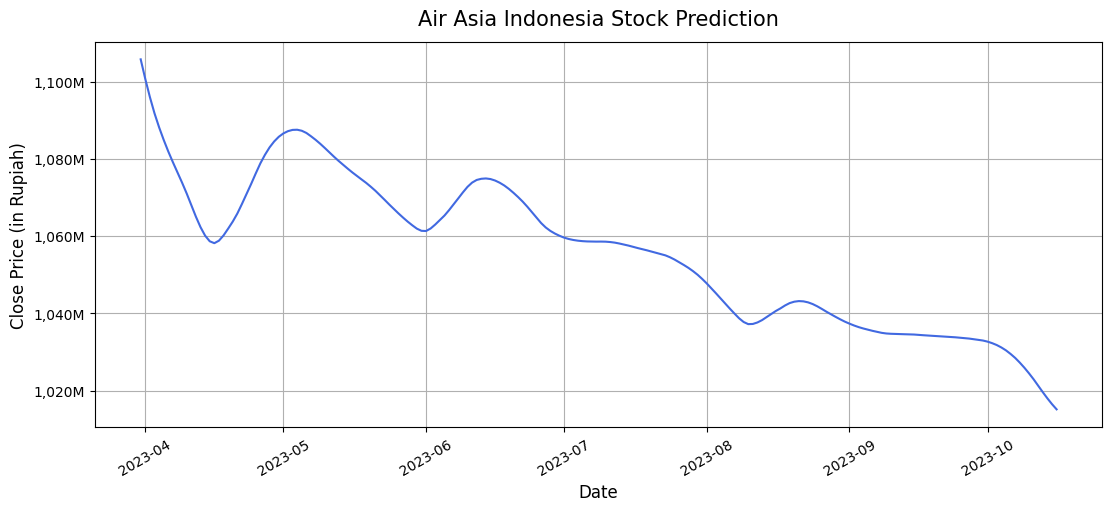

In [238]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [239]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 27s 577ms/step - loss: 0.0058 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0021 - val_loss: 6.3786e-04
Epoch 3/10
24/24 [==============================] - 11s 464ms/step - loss: 0.0014 - val_loss: 6.2166e-04
Epoch 4/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0012 - val_loss: 5.0655e-04
Epoch 5/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0012 - val_loss: 4.8874e-04
Epoch 6/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0010 - val_loss: 4.4011e-04
Epoch 7/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0010 - val_loss: 3.6637e-04
Epoch 8/10
24/24 [==============================] - 10s 421ms/step - loss: 9.3515e-04 - val_loss: 3.3793e-04
Epoch 9/10
24/24 [==============================] - 10s 422ms/step - loss: 8.7807e-04 - val_loss: 3.7200e-04
Epoch 10/10
24/24 [==============================] 

In [240]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 50ms/step
Mean Absolute Error (MAE): 0.0091981
Mean Absolute Percentage Error (MAPE): 0.06178
Root Mean Squared Error (RMSE): 0.01523
Mean Squared Error (MSE): 0.000232
R-Squared (R2): 0.960661
T-Statistic 0.7063
P-Value 3.547552111276044e-20
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 53ms/step


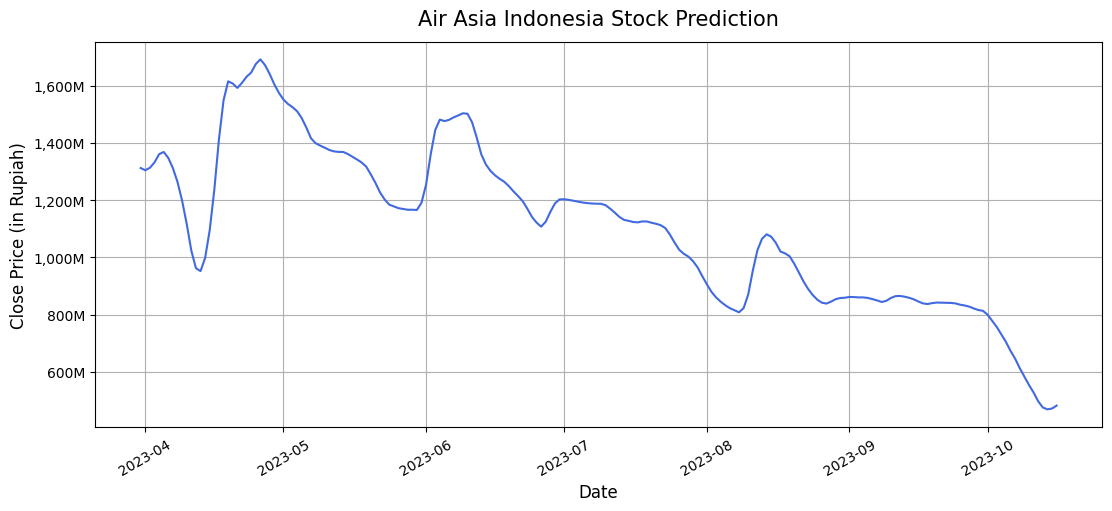

In [241]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [242]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 28s 604ms/step - loss: 0.0043 - val_loss: 7.7527e-04
Epoch 2/10
24/24 [==============================] - 11s 468ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 12s 485ms/step - loss: 0.0025 - val_loss: 7.8649e-04
Epoch 4/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0018 - val_loss: 6.6229e-04
Epoch 5/10
24/24 [==============================] - 14s 569ms/step - loss: 0.0018 - val_loss: 6.7279e-04
Epoch 6/10
24/24 [==============================] - 13s 518ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 11s 472ms/step - loss: 0.0018 - val_loss: 6.9239e-04
Epoch 8/10
24/24 [==============================] - 12s 505ms/step - loss: 0.0016 - val_loss: 5.3530e-04
Epoch 9/10
24/24 [==============================] - 13s 531ms/step - loss: 0.0014 - val_loss: 6.4374e-04
Epoch 10/10
24/24 [==============================] - 13s 524ms/

In [243]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 66ms/step
Mean Absolute Error (MAE): 0.0228472
Mean Absolute Percentage Error (MAPE): 0.19154
Root Mean Squared Error (RMSE): 0.02651
Mean Squared Error (MSE): 0.0007028
R-Squared (R2): 0.880836
T-Statistic 0.6814
P-Value 6.0911358876095856e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 1s 71ms/step


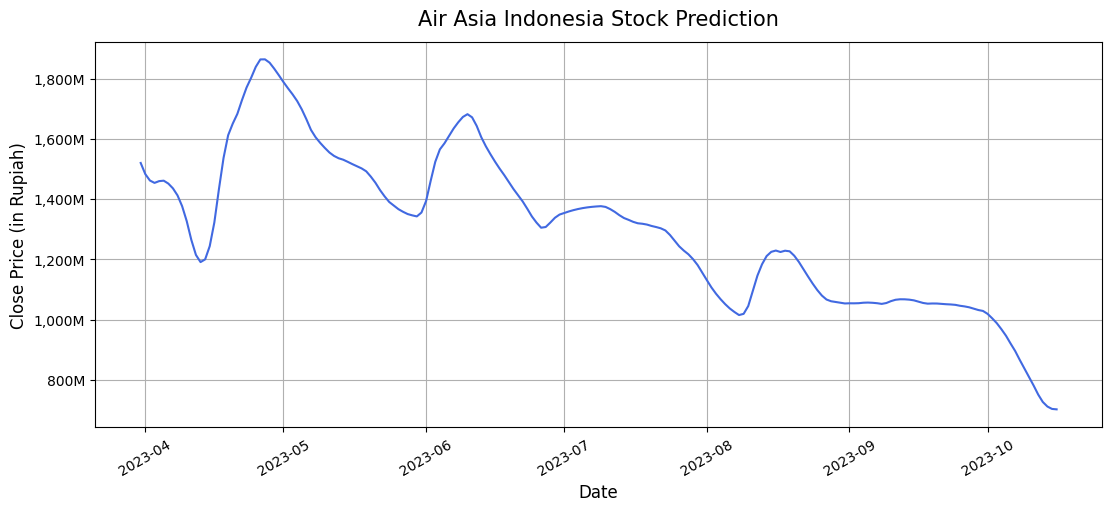

In [244]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [245]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 33s 671ms/step - loss: 0.0169 - val_loss: 0.0084
Epoch 2/10
24/24 [==============================] - 12s 487ms/step - loss: 0.0167 - val_loss: 0.0082
Epoch 3/10
24/24 [==============================] - 12s 512ms/step - loss: 0.0162 - val_loss: 0.0079
Epoch 4/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0160 - val_loss: 0.0077
Epoch 5/10
24/24 [==============================] - 11s 469ms/step - loss: 0.0158 - val_loss: 0.0075
Epoch 6/10
24/24 [==============================] - 12s 488ms/step - loss: 0.0155 - val_loss: 0.0073
Epoch 7/10
24/24 [==============================] - 12s 502ms/step - loss: 0.0155 - val_loss: 0.0071
Epoch 8/10
24/24 [==============================] - 11s 462ms/step - loss: 0.0150 - val_loss: 0.0069
Epoch 9/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0148 - val_loss: 0.0067
Epoch 10/10
24/24 [==============================] - 11s 474ms/step - loss: 0.0146 - val_lo

In [246]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 67ms/step
Mean Absolute Error (MAE): 0.1038361
Mean Absolute Percentage Error (MAPE): 0.73924
Root Mean Squared Error (RMSE): 0.12156
Mean Squared Error (MSE): 0.0147772
R-Squared (R2): -1.505614
T-Statistic 0.6765
P-Value 4.369507672699993e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 65ms/step


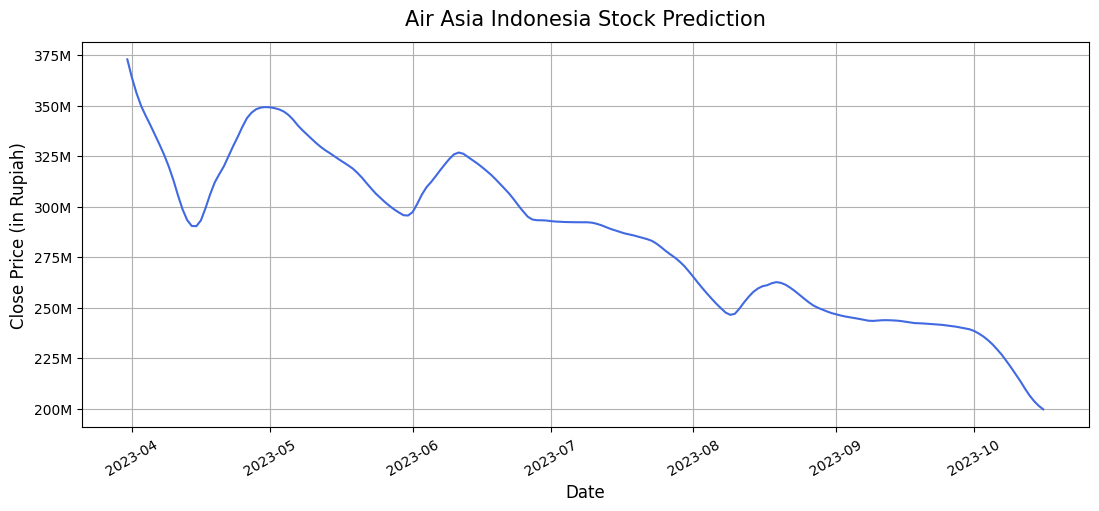

In [247]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [248]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 32s 634ms/step - loss: 0.0156 - val_loss: 0.0011
Epoch 2/10
24/24 [==============================] - 12s 486ms/step - loss: 0.0126 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 12s 487ms/step - loss: 0.0123 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 12s 480ms/step - loss: 0.0116 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0111 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 11s 458ms/step - loss: 0.0105 - val_loss: 0.0010
Epoch 7/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0101 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 11s 475ms/step - loss: 0.0097 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 12s 521ms/step - loss: 0.0095 - val_loss: 0.0010
Epoch 10/10
24/24 [==============================] - 12s 503ms/step - loss: 0.0090 - val_lo

In [249]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 60ms/step
Mean Absolute Error (MAE): 0.0396661
Mean Absolute Percentage Error (MAPE): 0.24196
Root Mean Squared Error (RMSE): 0.06989
Mean Squared Error (MSE): 0.0048848
R-Squared (R2): 0.171735
T-Statistic 0.6859
P-Value 8.315695165609604e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 0s 64ms/step


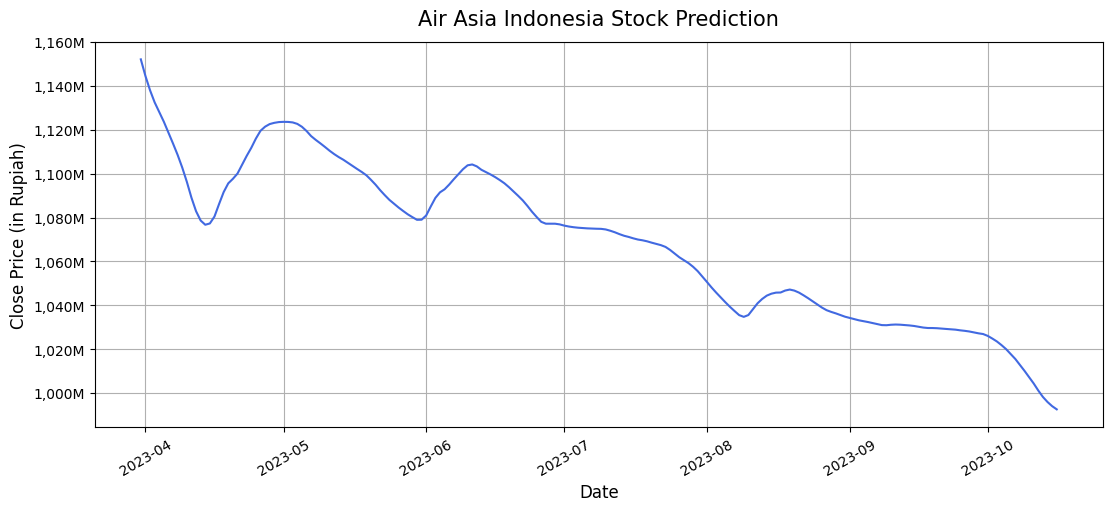

In [250]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [251]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 32s 625ms/step - loss: 0.0050 - val_loss: 8.4879e-04
Epoch 2/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0021 - val_loss: 9.7060e-04
Epoch 3/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0018 - val_loss: 7.4656e-04
Epoch 4/10
24/24 [==============================] - 11s 450ms/step - loss: 0.0016 - val_loss: 6.9649e-04
Epoch 5/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0016 - val_loss: 6.5826e-04
Epoch 6/10
24/24 [==============================] - 10s 410ms/step - loss: 0.0016 - val_loss: 6.4978e-04
Epoch 7/10
24/24 [==============================] - 11s 447ms/step - loss: 0.0015 - val_loss: 6.1446e-04
Epoch 8/10
24/24 [==============================] - 11s 448ms/step - loss: 0.0015 - val_loss: 5.8374e-04
Epoch 9/10
24/24 [==============================] - 12s 489ms/step - loss: 0.0013 - val_loss: 5.5616e-04
Epoch 10/10
24/24 [==============================] - 12

In [252]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 5s 74ms/step
Mean Absolute Error (MAE): 0.01253
Mean Absolute Percentage Error (MAPE): 0.09356
Root Mean Squared Error (RMSE): 0.01818
Mean Squared Error (MSE): 0.0003306
R-Squared (R2): 0.943951
T-Statistic 0.6842
P-Value 7.392309570407538e-21
Elapsed Time (min): 11.38


7/7 [==============================] - 1s 68ms/step


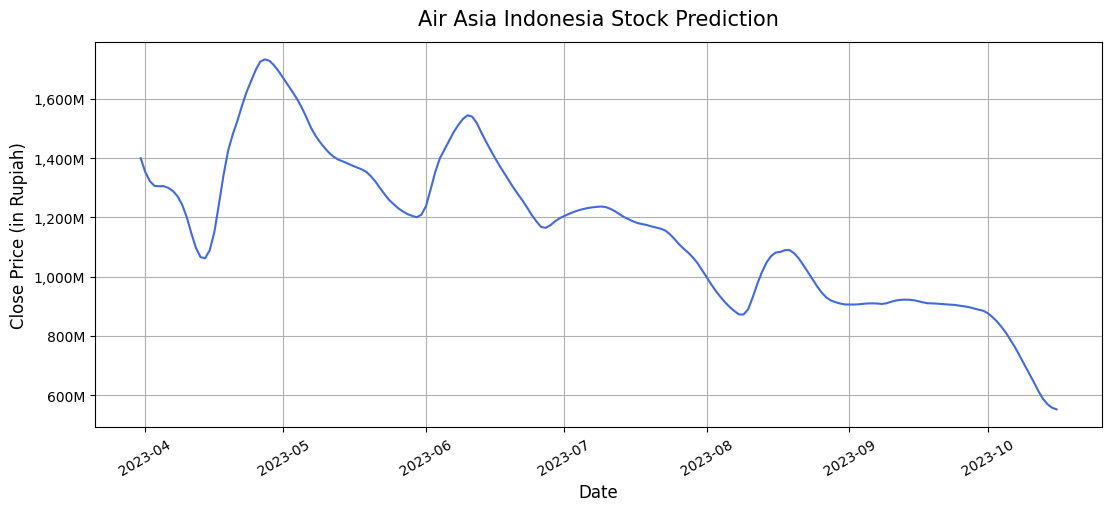

In [253]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [271]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 43ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 49ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 41ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 35ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 41ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 43ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 33ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 33ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 32ms/step
Training

In [272]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                67.61  0.11106   0.79135  0.01687   
           adagrad                 65.80  0.04634   0.27655  0.00671   
           adam                    64.17  0.01301   0.10634  0.00025   
           adamax                  66.21  0.01135   0.08064  0.00031   
           nadam                   76.25  0.01221   0.08217  0.00036   
           rmsprop                 69.12  0.03590   0.28160  0.00173   
           sgd                     63.90  0.03136   0.19871  0.00303   
relu       adadelta                68.25  0.11503   0.82131  0.01802   
           adagrad                 61.92  0.04414   0.26020  0.00605   
           adam                    60.76  0.00869   0.06026  0.00020   
           adamax                  63.39  0.01162   0.08048  0.00036   
           nadam                   66.97  0.01249   0.09071  0.00033   
           rmsprop                 70.39  0.01029   0.07280  0.00025   
           sgd                     69.26  0.03510   0.21254  0.00376   
sigmoid    adadelta                76.06  0.08803   0.81244  0.00953   
           adagrad                 70.18  0.29382   2.36510  0.09228   
           adam                    72.90  0.01214   0.08820  0.00030   
           adamax                  66.49  0.01541   0.10513  0.00050   
           nadam                   76.65  0.01169   0.08013  0.00034   
           rmsprop                 74.76  0.03170   0.26495  0.00126   
           sgd                     74.42  0.04430   0.26569  0.00603   
tanh       adadelta                69.47  0.13597   0.96861  0.02536   
           adagrad                 69.61  0.03784   0.23190  0.00448   
           adam                    66.66  0.01297   0.09316  0.00033   
           adamax                  76.64  0.01231   0.09027  0.00033   
           nadam                   71.67  0.00851   0.05868  0.00019   
           rmsprop                 71.67  0.01507   0.13196  0.00031   
           sgd                     75.14  0.03505   0.21787  0.00380   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   2.537502e-21          -1.86   0.12988     0.668442  
           adagrad    1.626821e-19          -0.14   0.08191     0.726626  
           adam       4.086867e-20           0.96   0.01581     0.708238  
           adamax     3.899886e-21           0.95   0.01761     0.674850  
           nadam      3.580250e-20           0.94   0.01897     0.706429  
           rmsprop    4.519550e-21           0.71   0.04159     0.677026  
           sgd        3.523798e-21           0.49   0.05505     0.673346  
relu       adadelta   9.962692e-22          -2.05   0.13424     0.654174  
           adagrad    1.791118e-19          -0.03   0.07778     0.727873  
           adam       4.245622e-20           0.97   0.01414     0.708757  
           adamax     5.408945e-21           0.94   0.01897     0.679663  
           nadam      3.326580e-20           0.94   0.01817     0.705421  
           rmsprop    4.112224e-21           0.96   0.01581     0.675633  
           sgd        9.375407e-21           0.36   0.06132     0.687635  
sigmoid    adadelta   4.214991e-21          -0.62   0.09762     0.675998  
           adagrad    1.210426e-24         -14.65   0.30378     0.537410  
           adam       5.473797e-21           0.95   0.01732     0.679837  
           adamax     7.649182e-22           0.91   0.02236     0.650057  
           nadam      4.220847e-20           0.94   0.01844     0.708678  
           rmsprop    9.505081e-20           0.79   0.03550     0.719579  
           sgd        7.973876e-22          -0.02   0.07765     0.650707  
tanh       adadelta   3.410256e-21          -3.30   0.15925     0.672860  
           adagrad    3.902951e-21           0.24   0.06693  

In [273]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
tanh       nadam                   71.67  0.00851   0.05868  0.00019   
relu       adam                    60.76  0.00869   0.06026  0.00020   
           rmsprop                 70.39  0.01029   0.07280  0.00025   
sigmoid    nadam                   76.65  0.01169   0.08013  0.00034   
relu       adamax                  63.39  0.01162   0.08048  0.00036   
linear     adamax                  66.21  0.01135   0.08064  0.00031   
           nadam                   76.25  0.01221   0.08217  0.00036   
sigmoid    adam                    72.90  0.01214   0.08820  0.00030   
tanh       adamax                  76.64  0.01231   0.09027  0.00033   
relu       nadam                   66.97  0.01249   0.09071  0.00033   
tanh       adam                    66.66  0.01297   0.09316  0.00033   
sigmoid    adamax                  66.49  0.01541   0.10513  0.00050   
linear     adam                    64.17  0.01301   0.10634  0.00025   
tanh       rmsprop                 71.67  0.01507   0.13196  0.00031   
linear     sgd                     63.90  0.03136   0.19871  0.00303   
relu       sgd                     69.26  0.03510   0.21254  0.00376   
tanh       sgd                     75.14  0.03505   0.21787  0.00380   
           adagrad                 69.61  0.03784   0.23190  0.00448   
relu       adagrad                 61.92  0.04414   0.26020  0.00605   
sigmoid    rmsprop                 74.76  0.03170   0.26495  0.00126   
           sgd                     74.42  0.04430   0.26569  0.00603   
linear     adagrad                 65.80  0.04634   0.27655  0.00671   
           rmsprop                 69.12  0.03590   0.28160  0.00173   
           adadelta                67.61  0.11106   0.79135  0.01687   
sigmoid    adadelta                76.06  0.08803   0.81244  0.00953   
relu       adadelta                68.25  0.11503   0.82131  0.01802   
tanh       adadelta                69.47  0.13597   0.96861  0.02536   
sigmoid    adagrad                 70.18  0.29382   2.36510  0.09228   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
tanh       nadam      3.712022e-20           0.97   0.01378     0.706924  
relu       adam       4.245622e-20           0.97   0.01414     0.708757  
           rmsprop    4.112224e-21           0.96   0.01581     0.675633  
sigmoid    nadam      4.220847e-20           0.94   0.01844     0.708678  
relu       adamax     5.408945e-21           0.94   0.01897     0.679663  
linear     adamax     3.899886e-21           0.95   0.01761     0.674850  
           nadam      3.580250e-20           0.94   0.01897     0.706429  
sigmoid    adam       5.473797e-21           0.95   0.01732     0.679837  
tanh       adamax     6.440384e-21           0.94   0.01817     0.682209  
relu       nadam      3.326580e-20           0.94   0.01817     0.705421  
tanh       adam       2.988064e-20           0.94   0.01817     0.703944  
sigmoid    adamax     7.649182e-22           0.91   0.02236     0.650057  
linear     adam       4.086867e-20           0.96   0.01581     0.708238  
tanh       rmsprop    7.035826e-21           0.95   0.01761     0.683493  
linear     sgd        3.523798e-21           0.49   0.05505     0.673346  
relu       sgd        9.375407e-21           0.36   0.06132     0.687635  
tanh       sgd        3.030387e-21           0.36   0.06164     0.671100  
           adagrad    3.902951e-21           0.24   0.06693     0.674861  
relu       adagrad    1.791118e-19          -0.03   0.07778     0.727873  
sigmoid    rmsprop    9.505081e-20           0.79   0.03550     0.719579  
           sgd        7.973876e-22          -0.02   0.07765     0.650707  
linear     adagrad    1.626821e-19          -0.14   0.08191     0.726626  
           rmsprop    4.519550e-21           0.71   0.04159  

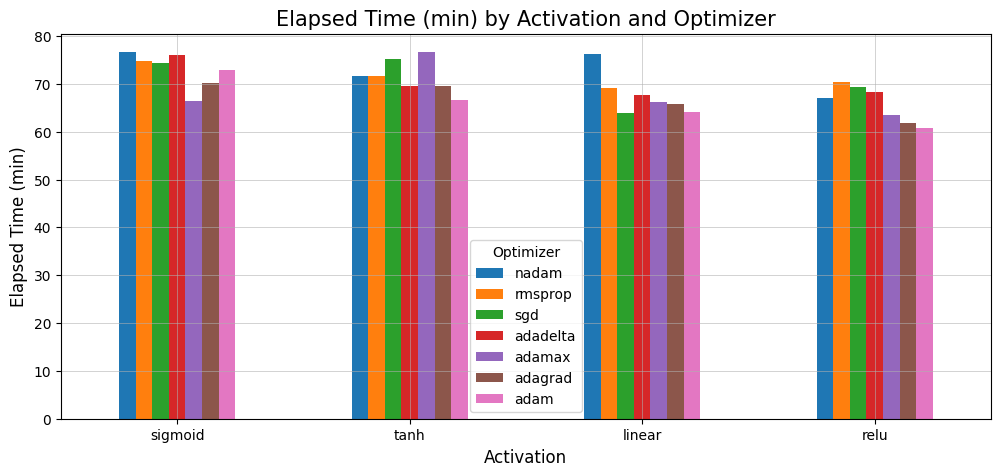

In [274]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

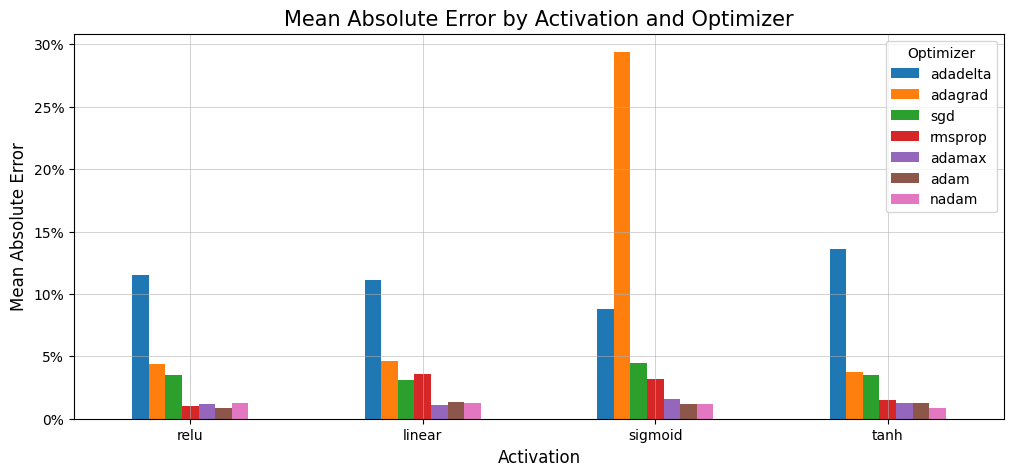

In [275]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

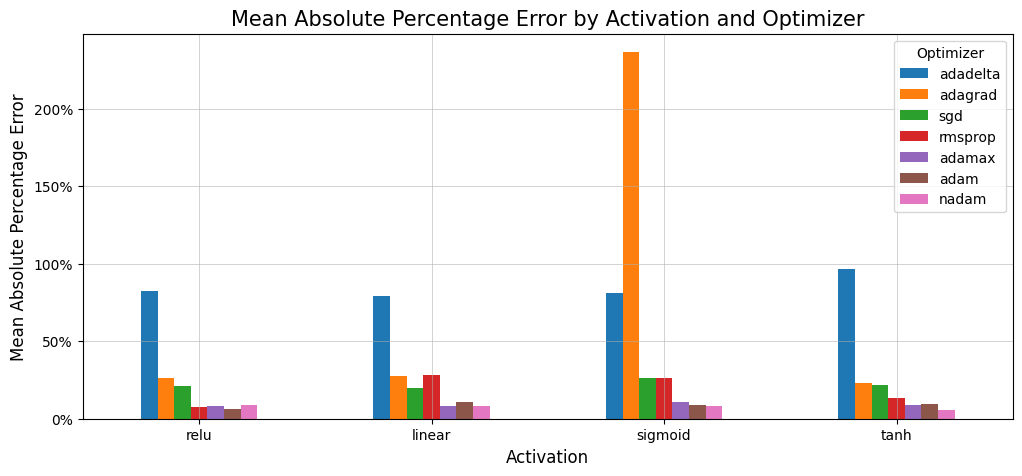

In [276]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

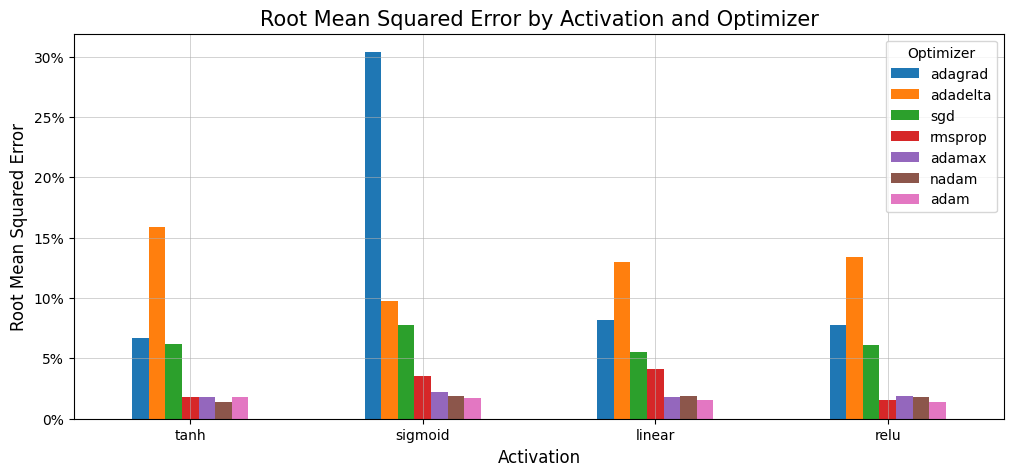

In [277]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

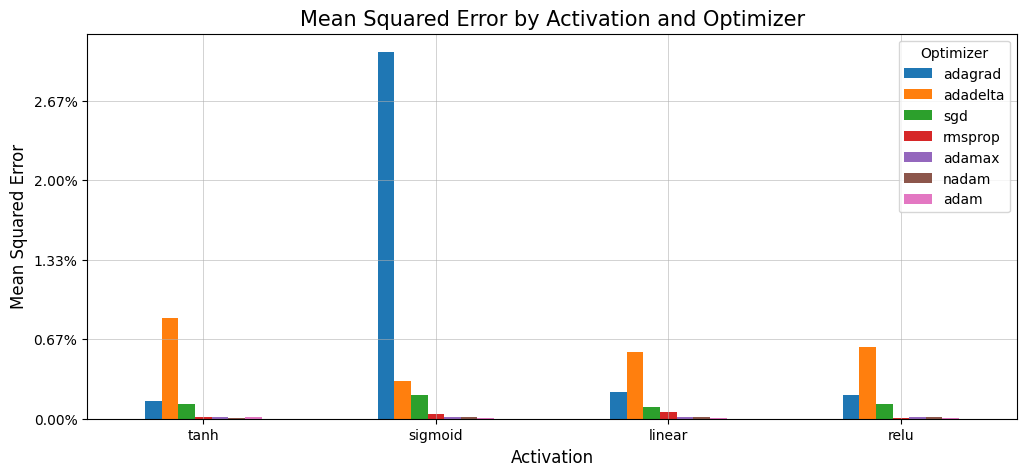

In [278]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=3, decimals=2) 
ax.yaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

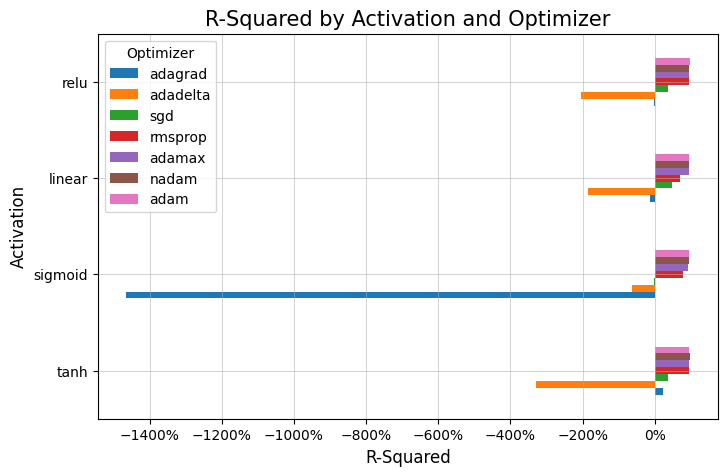

In [279]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=True)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()